[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyPartMC/blob/main/examples/immersion_freezing.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyPartMC/blob/main/examples/immersion_freezing.ipynb)    
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyPartMC.git/main?urlpath=lab/tree/examples/immersion_freezing.ipynb)    
[![ARM JupyterHub](https://img.shields.io/static/v1?label=launch%20in&logo=jupyter&color=lightblue&message=ARM+JupyterHub)](https://jupyterhub.arm.gov/hub/user-redirect/git-pull?repo=https%3A//github.com/open-atmos/PyPartMC&branch=main&urlPath=) (requires [logging in with ARM account](https://www.arm.gov/capabilities/computing-resources) and directing Jupyter to a notebook within the cloned repo)

In [1]:
# This file is a part of PyPartMC licensed under the GNU General Public License v3
# Copyright (C) 2025 University of Illinois Urbana-Champaign
# Authors:
#  - https://github.com/compdyn/partmc/graphs/contributors
#  - https://github.com/open-atmos/PyPartMC/graphs/contributors

In [2]:
import sys
import os
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyPartMC')
elif 'JUPYTER_IMAGE' in os.environ and '.arm.gov' in os.environ['JUPYTER_IMAGE']:
    !pip --quiet install PyPartMC open_atmos_jupyter_utils
    _pypartmc_path = !pip show PyPartMC | fgrep Location | cut -f2 -d' '
    sys.path.extend(_pypartmc_path if _pypartmc_path[0] not in sys.path else [])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot
import PyPartMC as ppmc
from PyPartMC import si

In [4]:
gas_data = ppmc.GasData(("SO2",))

In [5]:
aero_data = ppmc.AeroData(
    (
        #         density  ions in soln (1) molecular weight    kappa (1)
        #         |                     |   |                   |
        {"H2O": [1000 * si.kg / si.m**3, 0, 18.0 * si.g / si.mol, 0.00, 0, 0]},
        {"ILT": [2700 * si.kg / si.m**3, 0, 389.34 * si.g / si.mol, 0.003, 54.48075, -10.66873]},
    )
)

In [6]:
gas_state = ppmc.GasState(gas_data)

gas_state.mix_rats = (
    {"SO2": [0.0E+00]},
)

In [7]:
AERO_DIST_INIT = [
    {
        "init_small": {
            "mass_frac": [{"H2O": [0.76595745]}, {"ILT": [0.23404255]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 1.0e8 / si.m**3,
            "geom_mean_diam": 2.154434690031885 * si.um,
            "log10_geom_std_dev": 0.5,
        },
    }
]

aero_dist_init = ppmc.AeroDist(aero_data, AERO_DIST_INIT)

In [8]:
AERO_DIST_EMIT = {
    "gasoline": {
        "mass_frac": [{"H2O": [1.0]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 0 / si.m**3,
        "geom_mean_diam": 5e-8 * si.m,
        "log10_geom_std_dev": 0.24,
    },
}

In [9]:
gas_emit_times = [0]
gas_emit_rates = np.zeros(len(gas_emit_times))
emit_gas = [
    {"time": gas_emit_times},
    {"rate": list(gas_emit_rates)},
    {"SO2": [0]},
]

In [10]:
env_state = ppmc.EnvState(
    {
        "rel_humidity": 1.00,
        "latitude": 0,
        "longitude": 0,
        "altitude": 0 * si.m,
        "start_time": 21600 * si.s,
        "start_day": 200,
    }
)

In [11]:
time_timeseries = [0, 600]
pressure_timeseries = [50000.0, 50000.0]
temp_timeseries = [263.150, 243.150]
height_timeseries = [1000, 1000]

In [12]:
AERO_DIST_BACKGROUND = {
    "back_small": {
        "mass_frac": [{"H2O": [0.76595745]}, {"ILT": [0.23404255]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 0 / si.m**3,
        "geom_mean_diam": 0.02 * si.um,
        "log10_geom_std_dev": 0.161,
    },
}

In [13]:
times = [0 * si.s]
back_gas = [{"time": times},
            {"rate": [0.0 / si.s]},
            {"SO2": [0.0E+00]},
           ]

In [14]:
scenario = ppmc.Scenario(
    gas_data,
    aero_data,
    {
        "temp_profile": [{"time": time_timeseries}, {"temp": temp_timeseries}],
        "pressure_profile": [
            {"time": time_timeseries},
            {"pressure": pressure_timeseries},
        ],
        "height_profile": [{"time": time_timeseries}, {"height": height_timeseries}],
        "gas_emissions": emit_gas,
        "gas_background": back_gas,
        "aero_emissions": [
            {"time": [0 * si.s, 12 * 3600 * si.s]},
            {"rate": [1 / si.s, 0 / si.s]},
            {"dist": [[AERO_DIST_EMIT],[AERO_DIST_EMIT]]},
        ],
        "aero_background": [
            {"time": [0 * si.s]},
            {"rate": [1.5e-5 / si.s]},
            {"dist": [[AERO_DIST_BACKGROUND]]},
        ],
        "loss_function": "none",
    },
)

In [15]:
T_INITIAL = 0.0
scenario.init_env_state(env_state, T_INITIAL)

In [16]:
run_part_opt = ppmc.RunPartOpt(
    {
        "output_prefix": "urban_plume",
        "do_coagulation": False,
        "do_immersion_freezing": True,
        "t_max": 600 * si.s,
        "t_output": 600 * si.s,
        "del_t": 1 * si.s,
    }
)

In [17]:
N_PART = 10000
aero_state = ppmc.AeroState(aero_data, N_PART, 'nummass_source')
aero_state.dist_sample(
    aero_dist_init,
    sample_prop=1.0,
    create_time=0.0,
    allow_doubling=True,
    allow_halving=True,
)

3292

In [18]:
camp_core = ppmc.CampCore()
photolysis = ppmc.Photolysis()

In [19]:
N_STEPS = int(run_part_opt.t_max / run_part_opt.del_t)
time = np.zeros(N_STEPS + 1)
num_conc = np.zeros(N_STEPS + 1)
frozen_frac = np.zeros(N_STEPS + 1)
num_conc[0] = aero_state.total_num_conc
height = np.zeros((N_STEPS + 1))
temperature = np.zeros((N_STEPS + 1))
rh = np.zeros((N_STEPS + 1))

height[0] = env_state.height
temperature[0] = env_state.temp
rh[0] = env_state.rh

last_output_time = 0.
last_progress_time = 0.
i_output = 1

for i_time in range(1,N_STEPS + 1):
    (last_output_time, last_progress_time, i_output) = ppmc.run_part_timestep(
        scenario,
        env_state,
        aero_data,
        aero_state,
        gas_data,
        gas_state,
        run_part_opt,
        camp_core,
        photolysis,
        i_time,
        T_INITIAL,
        last_output_time,
        last_progress_time,
        i_output
    )
    num_conc[i_time] = aero_state.total_num_conc
    frozen_frac[i_time] = aero_state.frozen_fraction
    time[i_time] = env_state.elapsed_time
    height[i_time] = env_state.height
    temperature[i_time] = env_state.temp

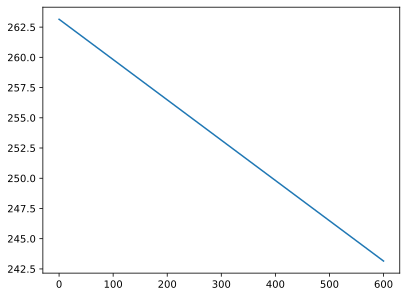

In [20]:
plt.plot(time,temperature)
plt.
show_plot()

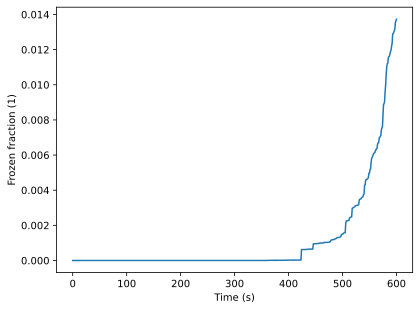

In [24]:
plt.plot(time,frozen_frac)
plt.xlabel('Time (s)')
plt.ylabel('Frozen fraction (1)')
show_plot()